# Data exploration notebook for the SIDER datasete

## 1. Import and process dataset

In [ ]:
import deepchem as dc
import pandas as pd
import numpy as np

# Helper function to combine ECFP and SMILES datasets
def dataset_to_df_with_smiles(ecfp_dataset, raw_dataset, tasks):
    X_list, y_list, ids_list, smiles_list = [], [], [], []
    
    # Iterate through both datasets in parallel
    for (X_batch, y_batch, w_batch, ids_batch), (X_raw, _, _, _) in zip(
        ecfp_dataset.iterbatches(batch_size=128, pad_batches=False),
        raw_dataset.iterbatches(batch_size=128, pad_batches=False)
    ):
        X_list.append(X_batch)
        y_list.append(y_batch)
        ids_list.extend(ids_batch)
        smiles_list.extend(X_raw)  # SMILES strings are in the raw features

    # Stack numerical and label arrays
    X_all = np.vstack(X_list)
    y_all = np.vstack(y_list)

    # Create DataFrames
    df_X = pd.DataFrame(X_all, columns=[f"fp_{i}" for i in range(X_all.shape[1])])
    df_y = pd.DataFrame(y_all, columns=tasks)
    df_y["mol_id"] = ids_list
    df_y["smiles"] = smiles_list

    # Combine all information into a single DataFrame
    df = pd.concat([df_y, df_X], axis=1)
    return df


# Load SIDER dataset with ECFP features (for model input)
tasks, datasets, transformers = dc.molnet.load_sider(featurizer='ECFP', splitter='scaffold')
train_ecfp, valid_ecfp, test_ecfp = datasets

# Load SIDER dataset again with raw SMILES (for visualization / metadata)
_, datasets_raw, _ = dc.molnet.load_sider(featurizer='Raw', splitter='scaffold')
train_raw, valid_raw, test_raw = datasets_raw

# Convert both representations to DataFrames
df_train = dataset_to_df_with_smiles(train_ecfp, train_raw, tasks)
df_valid = dataset_to_df_with_smiles(valid_ecfp, valid_raw, tasks)
df_test  = dataset_to_df_with_smiles(test_ecfp,  test_raw,  tasks)

# Basic dataset info
print(f"Number of tasks (side effects): {len(tasks)}")
print(f"Train samples: {len(df_train)}")
print(f"Validation samples: {len(df_valid)}")
print(f"Test samples: {len(df_test)}")

# Display the first few rows
df_train.head()



Number of tasks (side effects): 27
Train samples: 1141
Validation samples: 143
Test samples: 143


,Hepatobiliary disorders,Metabolism and nutrition disorders,Product issues,Eye disorders,Investigations,Musculoskeletal and connective tissue disorders,Gastrointestinal disorders,Social circumstances,Immune system disorders,Reproductive system and breast disorders,...,fp_1014,fp_1015,fp_1016,fp_1017,fp_1018,fp_1019,fp_1020,fp_1021,fp_1022,fp_1023
0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


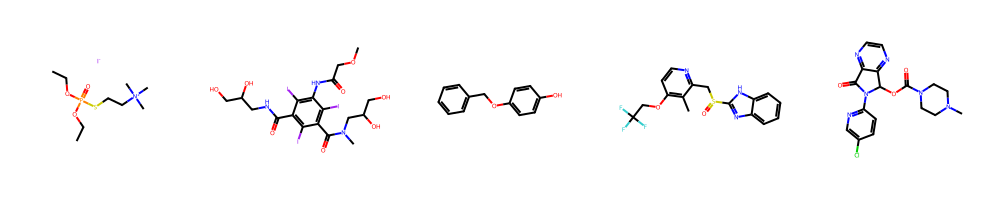

In [18]:
from rdkit import Chem
from rdkit.Chem import Draw

# Convert the first 5 SMILES into RDKit molecule objects
mols = [smi for smi in df_train["smiles"].head(5)]

# Display them in a grid
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200))

In [19]:
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import Counter

# Helper function to extract the Bemis–Murcko scaffold SMILES
def get_scaffold(smiles_or_mol):
    if isinstance(smiles_or_mol, str):
        mol = Chem.MolFromSmiles(smiles_or_mol)
    else:
        mol = smiles_or_mol
    if mol is None:
        return None
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    return Chem.MolToSmiles(scaffold)

# Compute scaffolds for each split
df_train["scaffold"] = df_train["smiles"].apply(get_scaffold)
df_valid["scaffold"] = df_valid["smiles"].apply(get_scaffold)
df_test["scaffold"]  = df_test["smiles"].apply(get_scaffold)

# Count unique scaffolds
scaffolds_train = set(df_train["scaffold"].dropna())
scaffolds_valid = set(df_valid["scaffold"].dropna())
scaffolds_test  = set(df_test["scaffold"].dropna())

print("Unique scaffolds in train:", len(scaffolds_train))
print("Unique scaffolds in validation:", len(scaffolds_valid))
print("Unique scaffolds in test:", len(scaffolds_test))

# Check overlaps between splits
overlap_train_valid = scaffolds_train.intersection(scaffolds_valid)
overlap_train_test  = scaffolds_train.intersection(scaffolds_test)
overlap_valid_test  = scaffolds_valid.intersection(scaffolds_test)

print("\nScaffold overlaps:")
print(f"Train ↔ Validation: {len(overlap_train_valid)}")
print(f"Train ↔ Test: {len(overlap_train_test)}")
print(f"Validation ↔ Test: {len(overlap_valid_test)}")


Unique scaffolds in train: 582
Unique scaffolds in validation: 143
Unique scaffolds in test: 143

Scaffold overlaps:
Train ↔ Validation: 0
Train ↔ Test: 0
Validation ↔ Test: 0


### Train / Validation / Test Split and Scaffold Integrity Check

The SIDER dataset has been split using a **scaffold-based splitter**, ensuring that molecules sharing the same core chemical structure (Bemis–Murcko scaffold) are placed in the **same subset**.  
This prevents overly optimistic performance caused by structurally similar molecules appearing in both the training and test sets.

**Dataset distribution:**
- Training set: 1,141 samples (~80%)
- Validation set: 143 samples (~10%)
- Test set: 143 samples (~10%)

These proportions are reasonable for model training and evaluation, providing a sufficiently large training set while keeping representative validation and test sets.

**Scaffold overlap analysis:**
- Unique scaffolds in training: 582  
- Unique scaffolds in validation: 143  
- Unique scaffolds in test: 143  
- Overlaps between splits: **0**

This confirms that the scaffold split has been performed correctly — the model will be evaluated on **completely unseen molecular scaffolds**, ensuring a fair assessment of its generalization ability.

If future experiments show instability in validation or test performance, we could consider increasing the validation or test proportions for better statistical robustness.


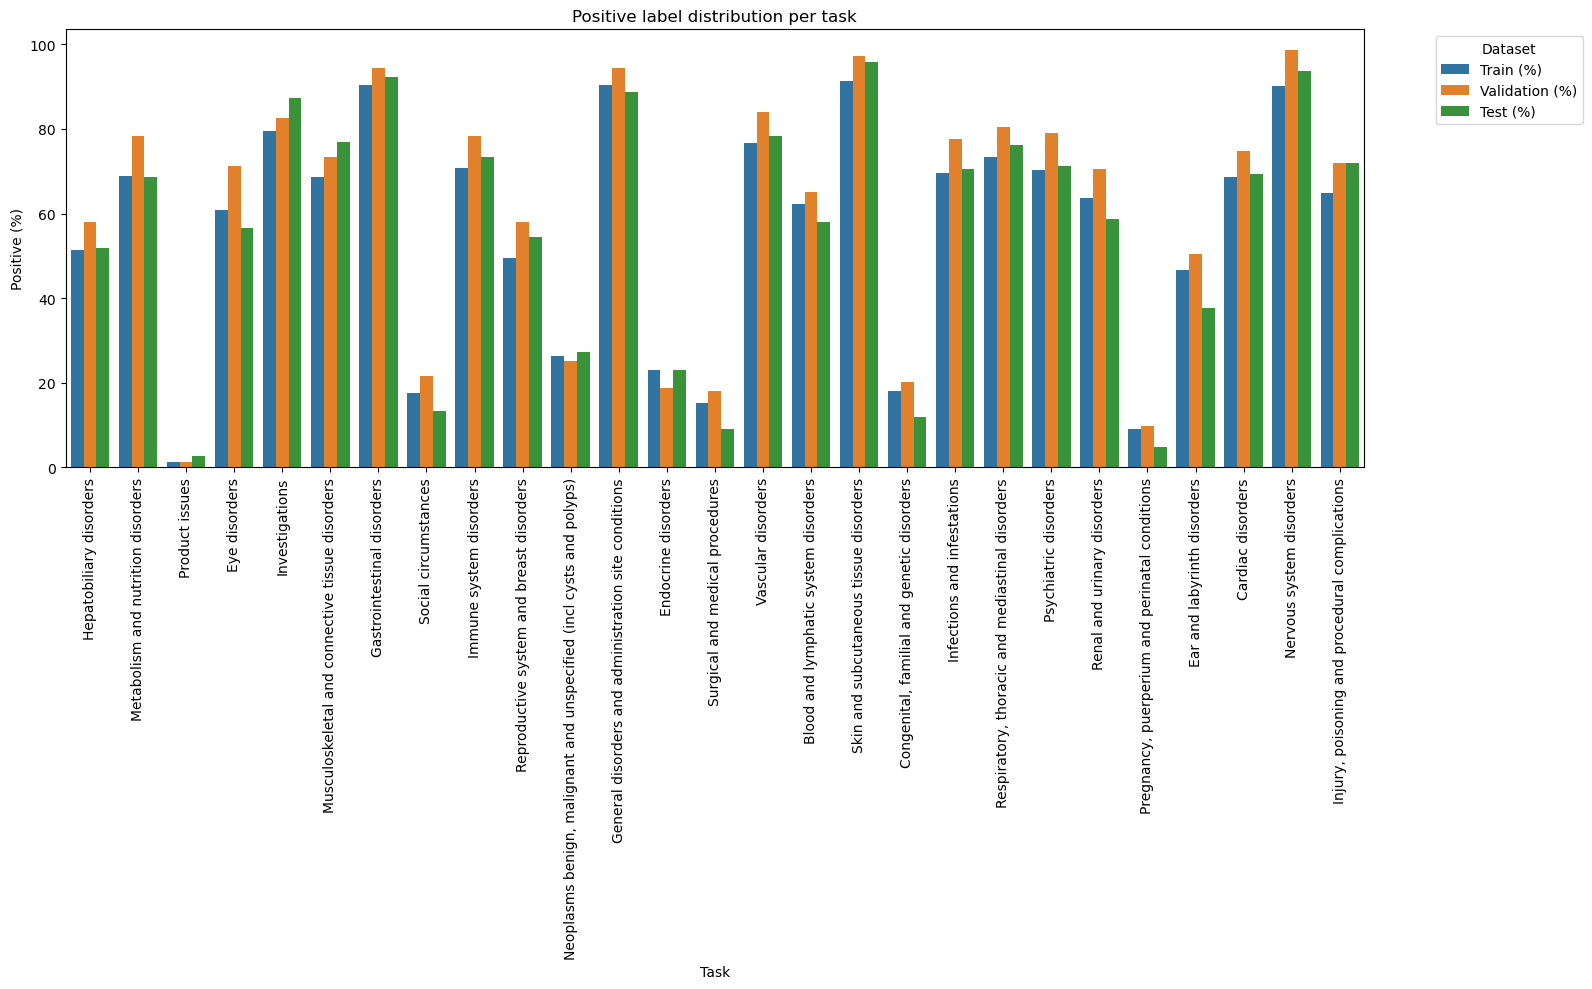

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Check label distribution ---
def plot_label_distribution(df_train, df_valid, df_test, tasks):
    train_pos = (df_train[tasks].sum() / len(df_train) * 100).round(2)
    valid_pos = (df_valid[tasks].sum() / len(df_valid) * 100).round(2)
    test_pos = (df_test[tasks].sum() / len(df_test) * 100).round(2)
    
    df_plot = pd.DataFrame({
        "Task": tasks,
        "Train (%)": train_pos.values,
        "Validation (%)": valid_pos.values,
        "Test (%)": test_pos.values
    })
    
    df_plot = df_plot.melt(id_vars="Task", var_name="Dataset", value_name="Positive (%)")
    
    plt.figure(figsize=(16,10))
    sns.barplot(data=df_plot, x="Task", y="Positive (%)", hue="Dataset")
    plt.xticks(rotation=90)
    plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Positive label distribution per task")
    plt.tight_layout()
    plt.show()

plot_label_distribution(df_train, df_valid, df_test, tasks)


### Label Distribution Analysis

The distribution of side effect labels across tasks in the training set is highly imbalanced. Some labels are well represented, such as "Skin and subcutaneous tissue disorders" (1,042 samples) or "Gastrointestinal disorders" (1,031 samples), while others are extremely rare, like "Product issues" (16 samples) or "Cardiac disorders" (~69 samples).

This imbalance presents several challenges:

- Rare labels are difficult for the model to predict accurately.
- There is a higher risk of overfitting on tasks with very few positive examples.
- Evaluation metrics need to account for this imbalance to avoid misleading results.

Overall, while most tasks have enough samples for learning, special care is required for rare labels to ensure meaningful predictions.

### Label Distribution Visualization

The bar plot above shows the number of positive examples per side effect label in the training set. We can observe a highly imbalanced distribution:

- Some labels, like "Skin and subcutaneous tissue disorders" (~1,042 samples) and "Gastrointestinal disorders" (~1,031 samples), are very common.
- Others, like "Product issues" (16 samples) and "Cardiac disorders" (~69 samples), are extremely rare.
- Several labels fall in between, such as "Hepatobiliary disorders" (~586 samples) or "Immune system disorders" (~807 samples).

This visualization confirms that the dataset is not evenly distributed across tasks. When training models, this imbalance should be taken into account, for example by using weighted loss functions, oversampling rare labels, or carefully monitoring overfitting on rare classes.

Overall, the plot gives a clear picture of which tasks are easier to learn (well-represented labels) and which tasks may require special attention (rare labels).


In [8]:
print("Missing values in features:", df_train.iloc[:, len(tasks):].isna().sum().sum())
print("Missing values in labels:", df_train[tasks].isna().sum())

Missing values in features: 0
Missing values in labels: Hepatobiliary disorders                                                0
Metabolism and nutrition disorders                                     0
Product issues                                                         0
Eye disorders                                                          0
Investigations                                                         0
Musculoskeletal and connective tissue disorders                        0
Gastrointestinal disorders                                             0
Social circumstances                                                   0
Immune system disorders                                                0
Reproductive system and breast disorders                               0
Neoplasms benign, malignant and unspecified (incl cysts and polyps)    0
General disorders and administration site conditions                   0
Endocrine disorders                                                 

In [9]:
for task in tasks:
    unique_vals = df_train[task].unique()
    print(f"{task}: {unique_vals}")

Hepatobiliary disorders: [1. 0.]
Metabolism and nutrition disorders: [1. 0.]
Product issues: [0. 1.]
Eye disorders: [1. 0.]
Investigations: [1. 0.]
Musculoskeletal and connective tissue disorders: [1. 0.]
Gastrointestinal disorders: [1. 0.]
Social circumstances: [1. 0.]
Immune system disorders: [1. 0.]
Reproductive system and breast disorders: [1. 0.]
Neoplasms benign, malignant and unspecified (incl cysts and polyps): [1. 0.]
General disorders and administration site conditions: [1. 0.]
Endocrine disorders: [0. 1.]
Surgical and medical procedures: [0. 1.]
Vascular disorders: [1. 0.]
Blood and lymphatic system disorders: [1. 0.]
Skin and subcutaneous tissue disorders: [1. 0.]
Congenital, familial and genetic disorders: [0. 1.]
Infections and infestations: [1. 0.]
Respiratory, thoracic and mediastinal disorders: [1. 0.]
Psychiatric disorders: [1. 0.]
Renal and urinary disorders: [1. 0.]
Pregnancy, puerperium and perinatal conditions: [1. 0.]
Ear and labyrinth disorders: [1. 0.]
Cardiac 

In [10]:
print("Feature shape:", df_train.iloc[:, len(tasks):].shape)
print("Unique values in features:", np.unique(df_train.iloc[:, len(tasks):].values))


Feature shape: (1141, 1026)


TypeError: '<' not supported between instances of 'float' and 'str'